In [52]:
import rasterio
import numpy as np
from rasterio.enums import Resampling
import geopandas as gpd
import json
from rasterio.mask import mask
from shapely.geometry import box
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.plot import show_hist
import matplotlib
import seaborn as sns

In [53]:
#Pre widfire images     24 December 2019
NIR_pre = rasterio.open('T55HFA_20191224T001101_B08_10m.jp2')
SWIR_pre = rasterio.open('T55HFA_20191224T001101_B12_20m.jp2')

#Post wildfire images   12 April 2020
NIR_post = rasterio.open('T55HFA_20200412T001111_B08_10m.jp2')
SWIR_post = rasterio.open('T55HFA_20200412T001111_B12_20m.jp2')

In [54]:
#Resample to apply arithmetic band operations
def resample(NIR_band, SWIR_band, output_name ):
    resample_factor = int(NIR_band.width / SWIR_band.width)
    resampled_SWIR  = SWIR_band.read(out_shape=(SWIR_band.count,SWIR_band.height * resample_factor,
                                          int(SWIR_band.width * resample_factor)),
                                          resampling=Resampling.bilinear)
    resampled_meta = SWIR_band.meta.copy()
    resampled_meta.update({"driver": "GTiff",
                        'height': resampled_SWIR.shape[1],
                        'width': resampled_SWIR.shape[2],
                        'transform': NIR_band.transform,
                        'crs': SWIR_band.crs})
    with rasterio.open(output_name, 'w', **resampled_meta) as clip:
            clip.write(resampled_SWIR)
            clip.close()

In [55]:
#Call resample function with a proper parameters
resample(NIR_pre, SWIR_pre, 'SWIR_pre_res.tif')
resample(NIR_post, SWIR_post, 'SWIR_post_res.tif')

In [56]:
#Clip function to select region of interest.
def clip(inputFile, outputFile):
    #Creating bounding box to clip ROI
    boundFrame = gpd.GeoDataFrame({'geometry': box(600000,6030000, 620000 , 6060000)}, index=[0], crs=inputFile.crs)
    jsonBox = [json.loads(boundFrame.to_json())['features'][0]['geometry']]
    clipped, clipped_transform = mask(dataset=inputFile, shapes=jsonBox, crop=True)
    clipped_meta = inputFile.meta.copy()
    clipped_meta.update({"driver": "GTiff",
                        'height': clipped.shape[1],
                        'width': clipped.shape[2],
                        'transform': clipped_transform,
                        'crs': inputFile.crs})
    
    #save as tif
    with rasterio.open(outputFile, 'w', **clipped_meta) as clip:
        clip.write(clipped)
        clip.close()

In [57]:
#Call clip functions with a proper parameters.

clip(NIR_pre, 'NIR_pre_clipped.tif')
clip(rasterio.open('SWIR_pre_res.tif'), 'SWIR_pre_clipped.tif')

clip(NIR_post, 'NIR_post_clipped.tif')
clip(rasterio.open('SWIR_post_res.tif'), 'SWIR_post_clipped.tif')

In [58]:
#Open pre wildfire clipped images
NIR_clipped_pre = rasterio.open('NIR_pre_clipped.tif')
SWIR_clipped_pre = rasterio.open('SWIR_pre_clipped.tif')

#Open ppost wildfire clipped images
NIR_clipped_post = rasterio.open('NIR_post_clipped.tif')
SWIR_clipped_post = rasterio.open('SWIR_post_clipped.tif')

In [59]:
#Numpy environment settings to apply arithmetic operations properly.
np.seterr(divide='ignore', invalid='ignore')

def NBR_Calc(NIR, SWIR, output):
    #Calculating Normalized Burn Ratio Index
    NBR = (NIR.read() - SWIR.read()) / (NIR.read() + SWIR.read())
    meta = NIR.meta.copy()
    meta.update(driver='GTiff')
    meta.update(dtype=rasterio.float32)

    with rasterio.open(output, 'w', **meta) as dst:
        dst.write(NBR.astype(rasterio.float32))
        dst.close()

In [60]:
#Calling NBR_Calc function to calculate pre and post wildfire.
NBR_Calc(NIR_clipped_pre, SWIR_clipped_pre, 'NBR_pre.tif')
NBR_Calc(NIR_clipped_post, SWIR_clipped_post, 'NBR_post.tif')

In [61]:
#Creating difference NBR values to detect how to change

def dnbr(preNBR, postNBR):
    dnbr = preNBR.read() - postNBR.read()
    meta = preNBR.meta.copy()
    meta.update(driver='GTiff')
    meta.update(dtype=rasterio.float32)

    with rasterio.open('dnbr.tif', 'w', **meta) as dst:
        dst.write(dnbr.astype(rasterio.float32))
        dst.close()

In [62]:
#Open NBR images
NBR_pre = rasterio.open('NBR_pre.tif')
NBR_post = rasterio.open('NBR_post.tif')

In [63]:
#Call dnbr function to calculate dnbr
dnbr(NBR_pre, NBR_post)

In [64]:
#open dnbr
dnbr = rasterio.open('dnbr.tif')

In [65]:
dnbr_copy = dnbr.read().copy()

#Reclassify to detect classes which are 
dnbr_copy[np.where(dnbr_copy > 0.66)] = 5                           #High severity burn
dnbr_copy[np.where((dnbr_copy > 0.44) & (dnbr_copy <= 0.66))] = 4   #Moderate-high severity burn
dnbr_copy[np.where((dnbr_copy > 0.27) & (dnbr_copy <= 0.44))] = 3   #Moderate-low severity burn
dnbr_copy[np.where((dnbr_copy > 0.1) & (dnbr_copy <= 0.27))] = 2    #Low-severity burn
dnbr_copy[np.where(dnbr_copy <= 0.1)] = 1                           #Unburned

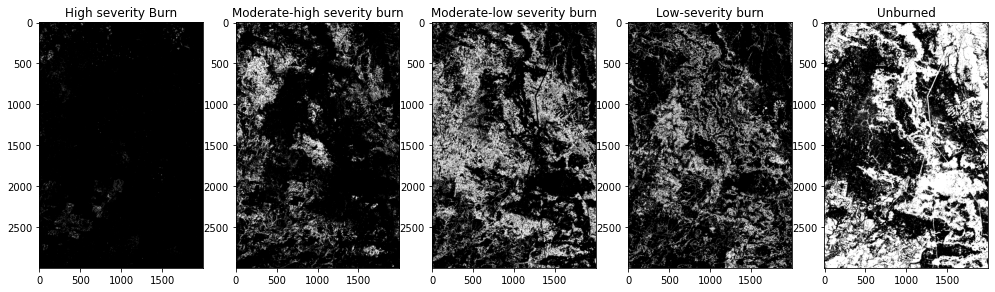

In [66]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(17,17))
ax1.imshow(dnbr_copy[0] == 5, cmap='gray')
ax1.title.set_text('High severity Burn')
ax2.imshow(dnbr_copy[0] == 4, cmap='gray')
ax2.title.set_text('Moderate-high severity burn')
ax3.imshow(dnbr_copy[0] == 3, cmap='gray')
ax3.title.set_text('Moderate-low severity burn')
ax4.imshow(dnbr_copy[0] == 2, cmap='gray')
ax4.title.set_text('Low-severity burn')
ax5.imshow(dnbr_copy[0] == 1, cmap='gray')
ax5.title.set_text('Unburned')
plt.show()

## The image where above is showing us to there are only 2 classses which are Unburned and High-severity

## The color scale select only 2 due to detected classes

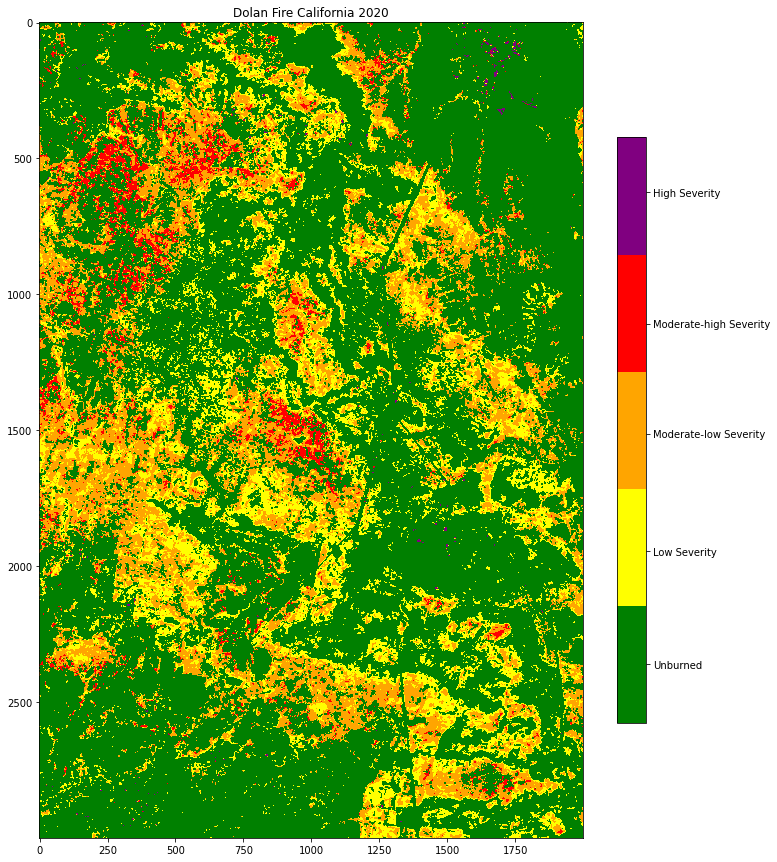

In [36]:
#Creating color map
cmap = matplotlib.colors.ListedColormap(['green','yellow','orange','red','purple'])
#Creating figure
fig, ax = plt.subplots(1, figsize=(15, 15))
plt.ticklabel_format(style = 'plain')
plt.title('Dolan Fire California 2020')
bounds = [-0.5, 0.1, 0.27, 0.440, 0.660, 1.3]    
norm = matplotlib.colors.BoundaryNorm(bounds, 5)
cax = plt.imshow(dnbr.read()[0], cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[-0.2, 0.18, 0.35, 0.53, 1])
cbar.ax.set_yticklabels(['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity'])

plt.show()
